# *Conexión al Drive*

In [1]:
# Crear conexion a drive

from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


# *Librerias*

In [2]:
###paquete para crear y trabajar con bases de datos.
import sqlite3 as sql
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objs as go ### para gráficos
import plotly.express as px
#import a_funciones as fn
from mlxtend.preprocessing import TransactionEncoder
import re
import shutil
import os
import sys

### *Creación de una copia de la base de datos original*

In [3]:
#
path='/content/drive/MyDrive/cod/marketing/MarketingprojectG8/data'
os.chdir(path)###volver la carpeta del repositorio directorio de trabajo
sys.path.append(path)### agregarla al path, para poder leer los archivos de funciones propios como paquetes

# Ruta de la base de datos copiada (new database file path)
copied_path = '/content/drive/MyDrive/cod/marketing/MarketingprojectG8/data/movies2'


# Construcción la ruta completa al archivo de base de datos de origen
source_file = os.path.join(path, 'db_movies')

# Crear una copia de la base de datos
shutil.copy(source_file, copied_path)

# Verificar que se haya copiado la base de datos
print(f"Database copied from '{source_file}' to '{copied_path}'")



Database copied from '/content/drive/MyDrive/cod/marketing/MarketingprojectG8/data/db_movies' to '/content/drive/MyDrive/cod/marketing/MarketingprojectG8/data/movies2'


# *Conexión a SQL*

In [4]:
# Conectar a la nueva base de datos copiada
con = sql.connect(copied_path)
cur= con.cursor()

# Consultar las tablas para verificar que la copia se realizó correctamente
cur.execute("SELECT name FROM sqlite_master WHERE type='table';")
tables = cur.fetchall()

print("Tablas en la base de datos copiada:")
for table in tables:
    print(table)

Tablas en la base de datos copiada:
('ratings',)
('movies',)


### *Cargar las tablas en DataFrames*

In [5]:
# Cargar tabla movies
cur.execute('SELECT * FROM movies')
movies_data = cur.fetchall()
movies_columns = [description[0] for description in cur.description]  # Obtener nombres de columnas
movies_df = pd.DataFrame(movies_data, columns=movies_columns)


In [6]:
# Mostrar las primeras filas de la tabla
movies_df.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [7]:
# Cargar tabla ratings
cur.execute('SELECT * FROM ratings')
ratings_data = cur.fetchall()
ratings_columns = [description[0] for description in cur.description]  # Obtener nombres de columnas
ratings_df = pd.DataFrame(ratings_data, columns=ratings_columns)

In [8]:
# Mostrar las primeras filas de la tabla
ratings_df.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


## *Nueva Tablas*





In [9]:
# Agregar las nuevas columnas 'movie_name' y 'year' a la tabla 'movies' si no existen
cur.execute("ALTER TABLE movies ADD COLUMN movie_name TEXT;")
cur.execute("ALTER TABLE movies ADD COLUMN year INTEGER;")

# Actualizar las columnas 'movie_name' y 'year' con los valores extraídos de 'title'
cur.execute("""
UPDATE movies
SET
    movie_name = TRIM(SUBSTR(title, 1, LENGTH(title) - 6)),  -- Extrae el nombre de la película
    year = CAST(SUBSTR(title, LENGTH(title) - 4, 4) AS INTEGER);  -- Extrae el año
""")

# Guardar los cambios con commit
con.commit()

# Consultar las primeras filas de la nueva tabla para verificar los datos
cur.execute("SELECT movieId, movie_name, year, genres FROM movies LIMIT 10;")
data = cur.fetchall()

# Mostrar los resultados
for row in data:
    print(row)

(1, 'Toy Story', 1995, 'Adventure|Animation|Children|Comedy|Fantasy')
(2, 'Jumanji', 1995, 'Adventure|Children|Fantasy')
(3, 'Grumpier Old Men', 1995, 'Comedy|Romance')
(4, 'Waiting to Exhale', 1995, 'Comedy|Drama|Romance')
(5, 'Father of the Bride Part II', 1995, 'Comedy')
(6, 'Heat', 1995, 'Action|Crime|Thriller')
(7, 'Sabrina', 1995, 'Comedy|Romance')
(8, 'Tom and Huck', 1995, 'Adventure|Children')
(9, 'Sudden Death', 1995, 'Action')
(10, 'GoldenEye', 1995, 'Action|Adventure|Thriller')


In [10]:
# Ejecutar la consulta SQL y cargar los resultados directamente en un DataFrame
data = "SELECT movieId, movie_name, year, genres FROM movies LIMIT 10;"

# Cargar los resultados en un DataFrame
movies_df = pd.read_sql(data, con)

# Mostrar los primeros resultados
movies_df.head()

,movieId,movie_name,year,genres
0,1,Toy Story,1995,Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji,1995,Adventure|Children|Fantasy
2,3,Grumpier Old Men,1995,Comedy|Romance
3,4,Waiting to Exhale,1995,Comedy|Drama|Romance
4,5,Father of the Bride Part II,1995,Comedy


## Nueva tabla Ratings

In [11]:
# Crear una nueva columna 'ratings_times' en la tabla 'ratings'
cur.execute("ALTER TABLE ratings ADD COLUMN ratings_times TEXT;")

# Actualizar la columna 'ratings_times' con el valor convertido de 'timestamp'
cur.execute("""
UPDATE ratings
SET ratings_times = datetime(timestamp, 'unixepoch');
""")

# Guardar los cambios con commit
con.commit()

# Consultar las primeras filas para verificar que 'ratings_times' esté correcto
cur.execute("SELECT movieId, userId, rating, ratings_times FROM ratings LIMIT 10;")
data = cur.fetchall()

# Mostrar los resultados
for row in data:
    print(row)

(1, 1, 4.0, '2000-07-30 18:45:03')
(3, 1, 4.0, '2000-07-30 18:20:47')
(6, 1, 4.0, '2000-07-30 18:37:04')
(47, 1, 5.0, '2000-07-30 19:03:35')
(50, 1, 5.0, '2000-07-30 18:48:51')
(70, 1, 3.0, '2000-07-30 18:40:00')
(101, 1, 5.0, '2000-07-30 18:14:28')
(110, 1, 4.0, '2000-07-30 18:36:16')
(151, 1, 5.0, '2000-07-30 19:07:21')
(157, 1, 5.0, '2000-07-30 19:08:20')


In [12]:
# Consulta SQL para obtener los datos de la tabla 'ratings' (incluyendo 'ratings_times')
data = """
SELECT movieId, userId, rating, ratings_times
FROM ratings
;
"""

# Cargar los resultados de la consulta directamente en un DataFrame
ratings_df = pd.read_sql(data, con)

# Mostrar los primeros resultados
ratings_df.head()

,movieId,userId,rating,ratings_times
0,1,1,4.0,2000-07-30 18:45:03
1,3,1,4.0,2000-07-30 18:20:47
2,6,1,4.0,2000-07-30 18:37:04
3,47,1,5.0,2000-07-30 19:03:35
4,50,1,5.0,2000-07-30 18:48:51


# *Cerra la conexion*

In [ ]:
# Cerrar la conexión
#cur.close()
#con.close()

# *Análisis exploratorio de los datos*

### *Verificar valores nulos en ambas tablas*

In [13]:
# Verificar valores nulos en las tablas
print("Valores nulos en movies:")
movies_df.isnull().sum()

Valores nulos en movies:


,0
movieId,0
movie_name,0
year,0
genres,0


In [14]:
print("Valores nulos en ratings:")
ratings_df.isnull().sum()

Valores nulos en ratings:


,0
movieId,0
userId,0
rating,0
ratings_times,0


### *Análisis de distribuciones y actividad de usuarios*

### *Distribución de calificaciones (ratings):*

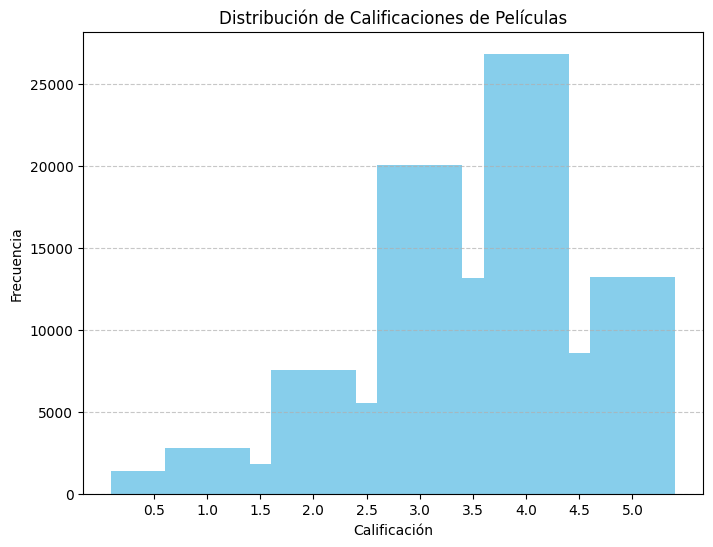

In [15]:
#Esto te dará la distribución de calificaciones en la tabla ratings, es decir,
#cuántas veces se ha dado cada calificación (por ejemplo, cuántas veces se dio un 5, un 4, etc.).

datos = pd.read_sql("""
SELECT rating, COUNT(*) AS conteo
FROM ratings
GROUP BY rating
ORDER BY rating DESC;""", con)

# Crear un gráfico de barras
plt.figure(figsize=(8, 6))  # Ajustar el tamaño de la figura si es necesario
plt.bar(datos['rating'], datos['conteo'], color='skyblue')
plt.title('Distribución de Calificaciones de Películas')
plt.xlabel('Calificación')
plt.ylabel('Frecuencia')
plt.xticks(datos['rating'])  # Establecer las marcas del eje x a los valores de calificación
plt.grid(axis='y', linestyle='--', alpha=0.7)  # Agregar una cuadrícula para una mejor legibilidad
plt.show()

### *Número de calificaciones por película:*

In [16]:
#Esto te dará las 10 películas más calificadas, es decir, aquellas que tienen más reseñas de usuarios.
pd.read_sql("""
SELECT
    movieId,
    COUNT(*) AS num_ratings
FROM
    ratings
GROUP BY
    movieId
ORDER BY
    num_ratings DESC
LIMIT 10;

""",con)

,movieId,num_ratings
0,356,329
1,318,317
2,296,307
3,593,279
4,2571,278
5,260,251
6,480,238
7,110,237
8,589,224
9,527,220


Número de calificaciones por usuario:

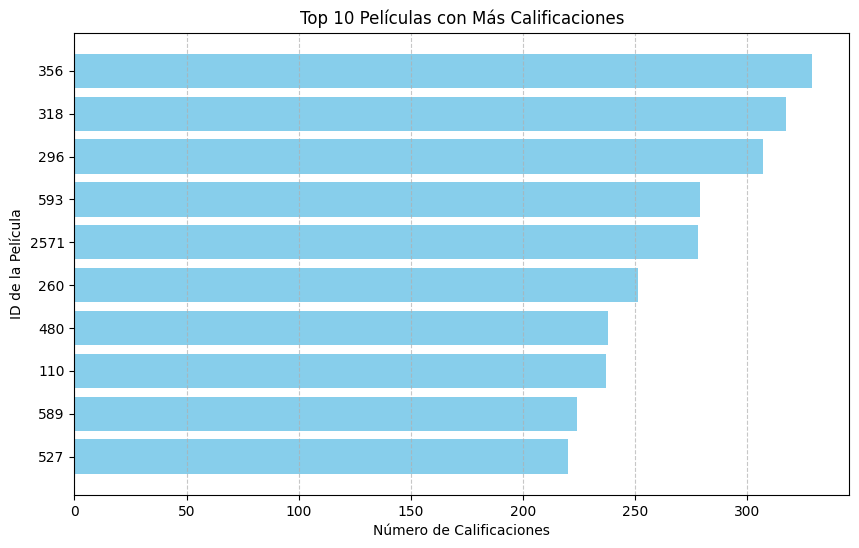

In [17]:
top_10_movies = pd.read_sql("""
SELECT
    movieId,
    COUNT(*) AS num_ratings
FROM
    ratings
GROUP BY
    movieId
ORDER BY
    num_ratings DESC
LIMIT 10;
""", con)

# Gráfico de barras horizontales
plt.figure(figsize=(10, 6))
plt.barh(top_10_movies['movieId'].astype(str), top_10_movies['num_ratings'], color='skyblue')  # Convertir movieId a string
plt.title('Top 10 Películas con Más Calificaciones')
plt.xlabel('Número de Calificaciones')
plt.ylabel('ID de la Película')
plt.gca().invert_yaxis()
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.show()

### *Usuarios que mas han calificado*

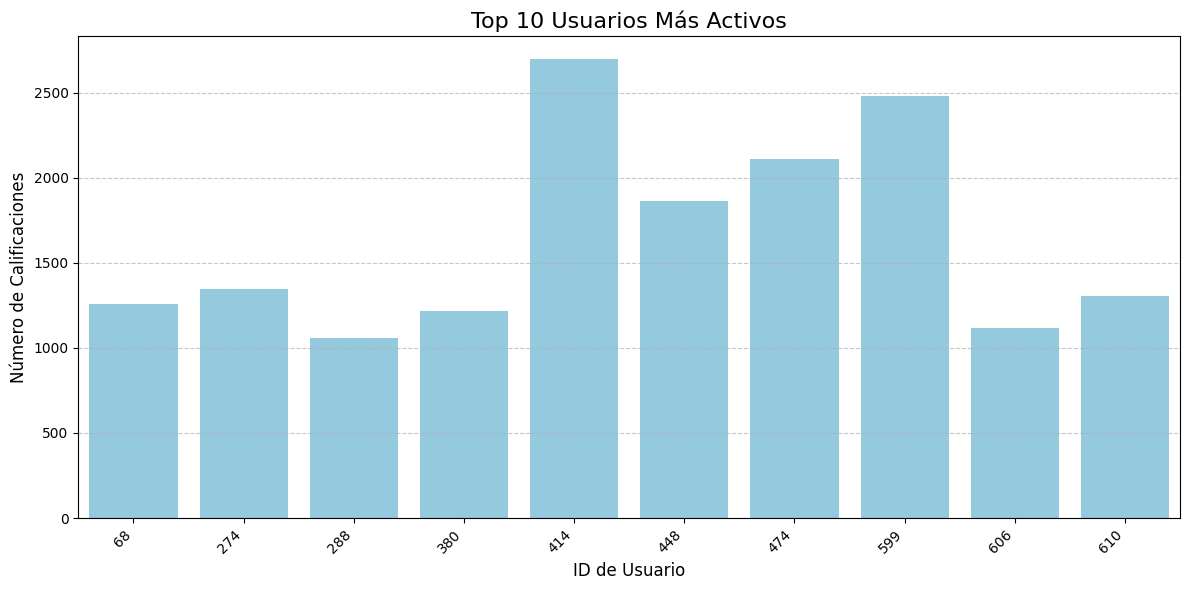

In [18]:
#Esto te permitirá ver qué usuarios han dado más calificaciones.
usuarios_mas_activos = pd.read_sql("""
SELECT
    userId,
    COUNT(*) AS num_ratings
FROM
    ratings
GROUP BY
    userId
ORDER BY
    num_ratings DESC
LIMIT 10;  -- Limitar a los 10 usuarios más activos
""", con)

# Crear el gráfico de barras
plt.figure(figsize=(12, 6))  # Ajustar el tamaño de la figura
sns.barplot(x='userId', y='num_ratings', data=usuarios_mas_activos, color='skyblue')
plt.title('Top 10 Usuarios Más Activos', fontsize=16)
plt.xlabel('ID de Usuario', fontsize=12)
plt.ylabel('Número de Calificaciones', fontsize=12)
plt.xticks(rotation=45, ha='right', fontsize=10)  # Rotar etiquetas del eje x
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()  # Ajustar el diseño para evitar superposiciones
plt.show()

### *Calificaciones promedio por año*

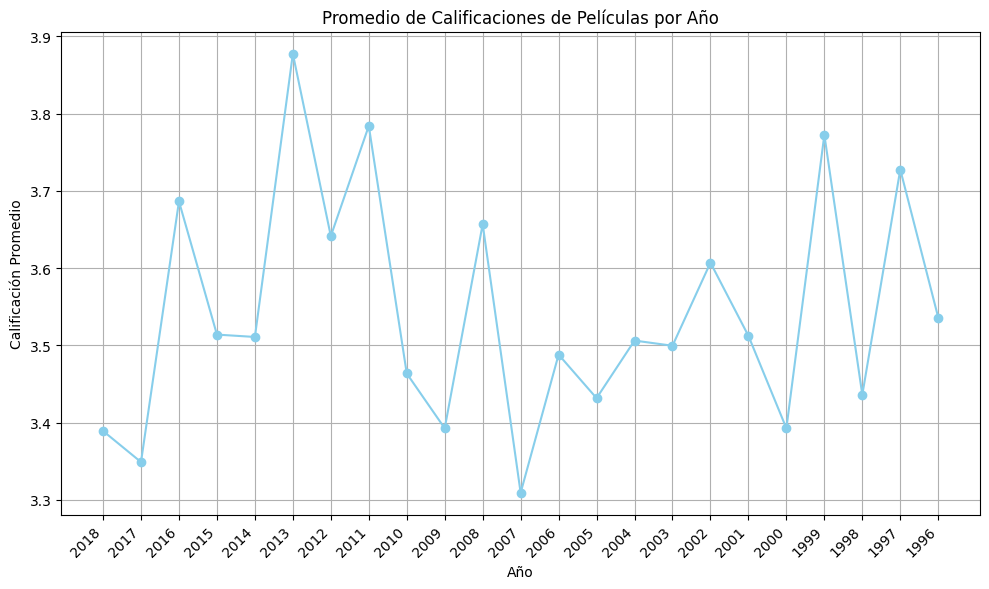

In [19]:
#Esto te dará el promedio de las calificaciones por año.
datos_promedio_calificaciones = pd.read_sql("""
SELECT
    strftime('%Y', datetime(timestamp, 'unixepoch')) AS year,
    AVG(rating) AS average_rating
FROM
    ratings
GROUP BY
    year
ORDER BY
    year DESC;
""", con)

# Crear el gráfico de líneas
plt.figure(figsize=(10, 6))  # Ajustar el tamaño de la figura si es necesario
plt.plot(datos_promedio_calificaciones['year'], datos_promedio_calificaciones['average_rating'], marker='o', linestyle='-', color='skyblue')
plt.title('Promedio de Calificaciones de Películas por Año')
plt.xlabel('Año')
plt.ylabel('Calificación Promedio')
plt.grid(True)  # Agregar una cuadrícula para una mejor legibilidad
plt.xticks(rotation=45, ha='right')  # Rotar las etiquetas del eje x para mejor legibilidad
plt.tight_layout()  # Ajustar el diseño para evitar superposiciones
plt.show()

### *Cantidad de películas por año*

In [20]:
# Recuento de películas por género
genre_counts = pd.read_sql("""
SELECT
    genres,
    COUNT(*) AS movie_count
FROM
    movies
GROUP BY
    genres
ORDER BY
    movie_count DESC;
""", con)

genre_counts


,genres,movie_count
0,Drama,1053
1,Comedy,946
2,Comedy|Drama,435
3,Comedy|Romance,363
4,Drama|Romance,349
...,...,...
946,Action|Adventure|Animation|Children|Sci-Fi,1
947,Action|Adventure|Animation|Children|Fantasy,1
948,Action|Adventure|Animation|Children|Comedy|Wes...,1
949,Action|Adventure|Animation|Children|Comedy|Sci...,1


### *Calificaciones mas bajas en promedio de los usuarios*



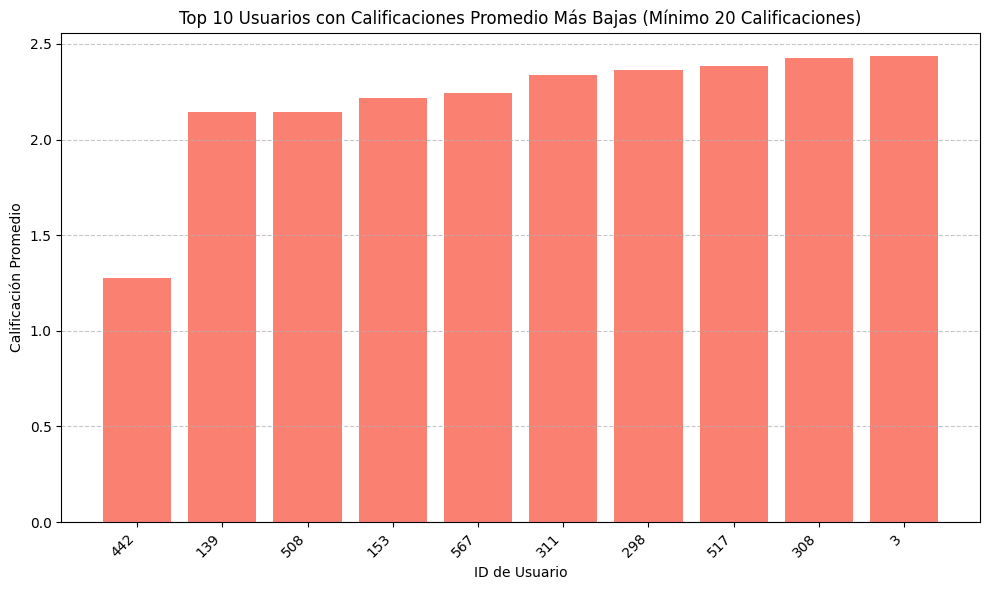

In [21]:
#Considerando solo a aquellos usuarios que han calificado al menos 20 películas.
usuarios_bajas_calificaciones = pd.read_sql("""
SELECT
    userId,
    AVG(rating) AS avg_rating,
    COUNT(rating) AS num_ratings
FROM
    ratings
GROUP BY
    userId
HAVING
    num_ratings >= 20
ORDER BY
    avg_rating ASC
LIMIT 10;
""", con)

# Crear el gráfico de barras
plt.figure(figsize=(10, 6))
plt.bar(usuarios_bajas_calificaciones['userId'].astype(str), usuarios_bajas_calificaciones['avg_rating'], color='salmon')
plt.title('Top 10 Usuarios con Calificaciones Promedio Más Bajas (Mínimo 20 Calificaciones)')
plt.xlabel('ID de Usuario')
plt.ylabel('Calificación Promedio')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()